# Stochastic heart

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
# import sparse matrices
from scipy.sparse import csr_matrix
import sdeint as sde
import os, sys
from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, Dopri5, PIDController
import diffrax
import jax
from jax import vmap, random
from jax import lax, ops
from jax.experimental import sparse
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

In [44]:


def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks

N_x=200
N_y=200
N=N_x*N_y
L1, c1=generate_laplacian(N_x, N_x, 0, sparse_matrix=True,seed=2)


In [38]:
y0 = jnp.zeros(2 * N, dtype=jnp.float32)
c1_flat = c1.flatten()
for i in range(N):
    if i % N_x == 0 and not c1_flat[i]:
        y0 = y0.at[i].set(0.1)

In [51]:

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N=N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=L1,c1=c1, sigma=0.001, delta_t=0.25, total_time=3000.0, key=random.PRNGKey(0)):
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        c1_flat = c1.flatten()
        for i in range(N):
            if i % N_x == 0 and not c1_flat[i]:
                y0 = y0.at[i].set(0.1)
    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    # Define the scan function
    def scan_fn(carry, _):
        u, v, key = carry
        key, subkey = random.split(key)
        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        return (u, v, key), (u, v)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), None, length=num_steps)

    return u_trajectory, v_trajectory


u_sol, v_sol = run_simulation( N=N, L=L1, c1=c1)


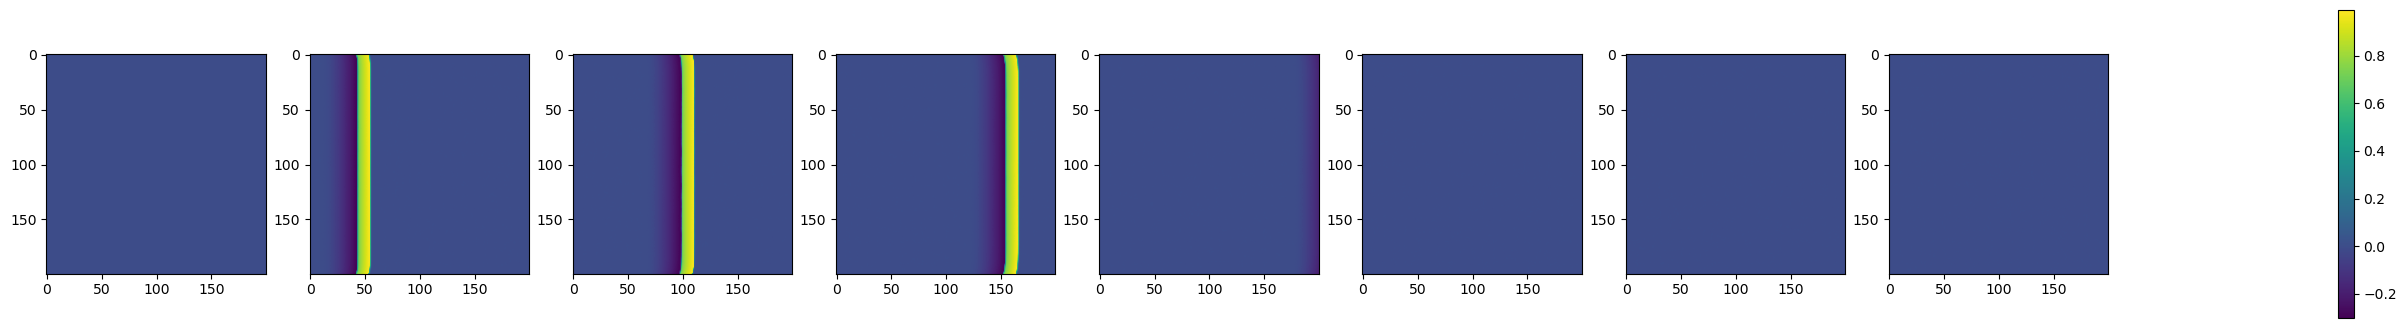

In [52]:
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = u_sol.min()
max = u_sol.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol[int((i/len(axs)*int(3000/0.25))),:].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

In [ ]:

c1 = c1.flatten()
u_sol=u_sol.T
v_sol=v_sol.T
u_plot = np.array(u_sol[~c1, :])
v_plot = np.array(v_sol[~c1, :])
##u_plot = np.array(u_sol[c1, :])
#v_plot = np.array(v_sol[c1, :])

# Plotting function
def plot_uv(u, v):
    plt.plot(u, v)  

# Plot each (u, v) pair for a subsample
#subsample_indices = np.random.choice(len(u_plot), size=100, replace=False)
for idx in range(len(u_plot)):
    plot_uv(u_plot[idx], v_plot[idx])

plt.xlabel('u')
plt.ylabel('v')
plt.show()
print(len(u_plot))